In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
import tensorflow as tf

In [2]:
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense
from tensorflow.keras.layers import  Embedding, LSTM
from sklearn.model_selection import train_test_split

In [3]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [4]:
data = pd.read_csv("IMDB dataset.csv")

In [5]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [6]:
# Checking for missing values

data.isnull().values.any()

False

In [7]:
data["review"][2]

# You can see that our text contains punctuations, brackets, HTML tags and numbers 
# I have preprocess this text in the next section

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

In [8]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)

In [11]:
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''
    
    sentence = sen.lower()

    # Remove html tags
    sentence = remove_tags(sentence)

    # Remove apostrophes 
    sentence =  re.sub("'", '', sentence)
    
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.     # Remove Stopwords
   
    return sentence

In [12]:
text = preprocess_text("Those were the best days of my lif!")
print(text)

those were the best days of my lif 


In [13]:
# Calling preprocessing_text function on movie_reviews

X = []
sentences = list(data['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [14]:
# Sample cleaned up movie review 

X[0]

'one of the other reviewers has mentioned that after watching just oz episode youll be hooked they are right as this is exactly what happened with me the first thing that struck me about oz was its brutality and unflinching scenes of violence which set in right from the word go trust me this is not show for the faint hearted or timid this show pulls no punches with regards to drugs sex or violence its is hardcore in the classic use of the word it is called oz as that is the nickname given to the oswald maximum security state penitentary it focuses mainly on emerald city an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda em city is home to many aryans muslims gangstas latinos christians italians irish and more so scuffles death stares dodgy dealings and shady agreements are never far away would say the main appeal of the show is due to the fact that it goes where other shows wouldnt dare forget pretty picture

In [15]:
# Converting sentiment labels to 0 & 1

y = data['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# The train set will be used to train our deep learning models 
# while test set will be used to evaluate how well our model performs 

In [17]:
# Embedding layer expects the words to be in numeric form 
# Using Tokenizer function from keras.preprocessing.text library
# Method fit_on_text trains the tokenizer 
# Method texts_to_sequences converts sentences to their numeric form

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [18]:
vocab = word_tokenizer.word_index

In [19]:
import io
import json

In [20]:
# Saving
tokenizer_json = word_tokenizer.to_json()
with io.open('b3_tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [21]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

vocab_length = len(vocab) + 1

vocab_length

98510

In [22]:
def getMaxLen(X):
 maxlen = 0
 for sent in X:
    sent_len = len(sent)
    if sent_len > maxlen:
        maxlen = sent_len
 return maxlen

In [23]:
def getAvgLen(X):
 lenght = 0
 for sent in X:
    sent_len = len(sent)
    lenght += sent_len
 return lenght//len(X)

In [24]:
print(getMaxLen(X))

13091


In [25]:
print(getAvgLen(X))

1225


In [26]:
# Padding all reviews to fixed length
maxlen = 128
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [27]:
print(X_train)

[[  11  616    3 ...  201  345 3816]
 [   1  264    5 ...   86  100    7]
 [ 557 1311  108 ...    0    0    0]
 ...
 [ 788    8   24 ...    0    0    0]
 [   8  347   10 ...    0    0    0]
 [  14  251  115 ...   63   70 1945]]


In [28]:
# Load GloVe word embeddings and create an Embeddings Dictionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [29]:
print(len(embeddings_dictionary))

400000


In [30]:
# Create Embedding Matrix having 100 columns 
# Containing 100-dimensional GloVe word embeddings for all words in our corpus.
embed_size = 100
embedding_matrix = zeros((vocab_length,embed_size ))
for word, index in vocab.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [31]:
embedding_matrix.shape

(98510, 100)

In [32]:

LSTM_model = Sequential()
embedding_layer = Embedding(input_dim =vocab_length,
          output_dim = embed_size,
          input_shape = (maxlen,)
         )
LSTM_model.add(embedding_layer)
LSTM_model.add(LSTM(128))
LSTM_model.add(Dense(1, activation='sigmoid'))

LSTM_model.layers[0].set_weights([embedding_matrix])
LSTM_model.layers[0].trainable = False

C:\Users\MuhammadAhmadBajwa\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [33]:
# Model compiling

LSTM_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(LSTM_model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 128, 100)            │       9,851,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 128)                 │         117,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,968,377 (38.03 MB)

 Trainable params: 117,377 (458.50 KB)

 Non-trainable params: 9,851,000 (37.58 MB)

None


In [34]:
# Model Training

lstm_model_history = LSTM_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 66s 259ms/step - acc: 0.6586 - loss: 0.6109 - val_acc: 0.7824 - val_loss: 0.4759
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 64s 255ms/step - acc: 0.7854 - loss: 0.4646 - val_acc: 0.8080 - val_loss: 0.4214
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 63s 250ms/step - acc: 0.8131 - loss: 0.4102 - val_acc: 0.7990 - val_loss: 0.4073
Epoch 4/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 63s 252ms/step - acc: 0.8303 - loss: 0.3781 - val_acc: 0.8443 - val_loss: 0.3529
Epoch 5/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 63s 253ms/step - acc: 0.8499 - loss: 0.3478 - val_acc: 0.8522 - val_loss: 0.3394
Epoch 6/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 64s 254ms/step - acc: 0.8593 - loss: 0.3253 - val_acc: 0.8531 - val_loss: 0.3349


In [35]:
# Predictions on the Test Set

score = LSTM_model.evaluate(X_test, y_test, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - acc: 0.8554 - loss: 0.3303


In [36]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3284291625022888
Test Accuracy: 0.8557000160217285


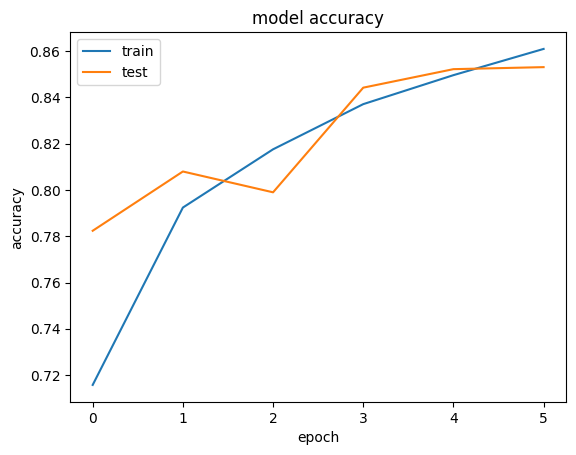

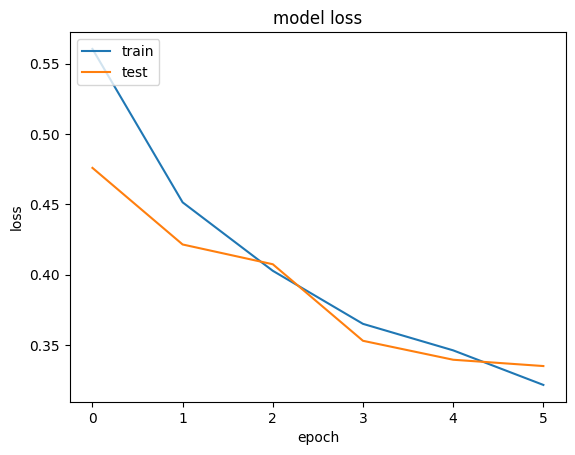

In [37]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [37]:
LSTM_model.save('Sentiment_Analysis_Model.h5')

In [125]:
######################################  SINGLE PREDICTION
review = 'The movie lead overacted too much'

In [126]:
# Preprocess Data
review_processed = preprocess_text(review)
print('Processed = ',review_processed)

Processed =  the movie lead overacted too much


In [127]:
# Convert to sequence
review_seq = word_tokenizer.texts_to_sequences([review_processed])
print('Sequence = ',review_seq)

Sequence =  [[1, 14, 462, 9770, 95, 70]]


In [128]:
# Padding the sequence 
maxlen = 100
review_padded = pad_sequences(review_seq,padding='post',maxlen=maxlen)
print(review_padded)

[[   1   14  462 9770   95   70    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]]


In [129]:
# Predict using trained Model
result = LSTM_model.predict(review_padded)
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
[[0.30792624]]


In [130]:
if result > 0.5:
    print('Positive Review')
else:
    print('Negative Review')

Negative Review
